1. Import all the libraries

In [2]:
import json
import requests
import pandas as pd # module to convert an address into latitude and longitude values
import geopandas as gpd
import numpy as num
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim 
from IPython.display import display
from pandas import json_normalize
from matplotlib.cm import rainbow
from sklearn.cluster import KMeans

2. Extract Data from WikiPedia Page

Used the old link as the table is easier to extract the data

In [ ]:
#Postal Code and Neighborhood Name Data

#Reading tables with pandas from url
tables = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=876823784')

#New dataframe with first table
df = tables[0]

#Create a new dataframe drop Not assigned in Borough
df1 = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)

#Retrieve Table from HTML without any assigned value
postalCodeWithNeighborhoodName = df1.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
postalCodeWithNeighborhoodName.reset_index(inplace=True)
postalCodeWithNeighborhoodName['Neighbourhood'] = num.where(postalCodeWithNeighborhoodName['Neighbourhood'] == 'Not assigned', postalCodeWithNeighborhoodName['Borough'], postalCodeWithNeighborhoodName['Neighbourhood'])
postalCodeWithNeighborhoodName.rename(columns={'Postcode':'Postal Code'}, inplace=True)

#Sort by Postal Code (Ascending)
postalCodeWithNeighborhoodName.sort_values(['Postal Code'], inplace=True)
postalCodeWithNeighborhoodName = postalCodeWithNeighborhoodName.reset_index(drop=True)

#Output Clean up version to excel sheet
postalCodeWithNeighborhoodName.to_csv("CleanDataSet/PostalCodeWithNeighborhoodName.csv")
postalCodeWithNeighborhoodName


,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


3. Read in Dataset for Postal Code, Latitude, and Longitude

In [ ]:
#Postal Code, Longitude, Latitude Data
postalCodeLongLat = pd.read_csv('Datasets/Geospatial_Coordinates.csv')
postalCodeLongLat.rename(columns={'Postal Code':'Postal Code'}, inplace=True)
postalCodeLongLat.to_csv("CleanDataSet/PostalCode_Longitude_Latitude.csv")

#Sort the postal code (Ascending)
postalCodeLongLat.sort_values(['Postal Code'], inplace=True)
postalCodeLongLat = postalCodeLongLat.reset_index(drop=True)

postalCodeLongLat

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


4. Merge Wikipedia Page and Postal Code With Latitude and Longitude

In [ ]:
#Join the data only if the postal code key matches
mergeData = pd.merge(postalCodeWithNeighborhoodName, postalCodeLongLat, on='Postal Code')

#Sort the data in terms of postal code (Ascending Order)
mergeData.sort_values(['Postal Code'], inplace=True)
mergeData = mergeData.reset_index(drop=True)
#mergeData.rename(columns={'Postal Code':'Postal Code', 'Postal Code':'Postal Code', 'Neighbourhood': 'Neighbourhood', 'District': 'District', 'Latitude':'Latitude', 'Longitude':'Longitude'}, inplace=True)

#Output Clean up version to excel sheet
mergeData.to_csv('CleanDataSet/MergedPostalCodeandLatitudeLongitude.csv')
mergeData

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


5. Read in Toronto's 2016 Neighbourhood Statistics

In [ ]:
#Load CSV File
df = pd.read_csv(r'Datasets/neighbourhood-profiles-2016.csv')

#Drop first 3 columns
df.drop(df.columns[[0,1,3]], inplace=True, axis = 1)

#Transpose the data
df.set_index('Topic', inplace = True)
NeighborhoodIncomes = df.transpose()

#Write the Transposed version to CSV
NeighborhoodIncomes.to_csv("Datasets/transposedVersion.csv")

#Read in the transposed data
dataset = pd.read_csv(r'Datasets/transposedVersion.csv')

#Create New Data frame and Drop the first and second row
df = pd.DataFrame(dataset)
df.drop([df.index[0], df.index[1]], inplace=True)
cols = [0,3]

#Retrieve the Neighbourhoods and Population
neighborhoodtotalPopulation = df[df.columns[cols]]
neighborhoodtotalPopulation.rename(columns={'Unnamed: 0':'Neighbourhood', 'Population and dwellings':'Population'}, inplace=True)
NeighborhoodIncomes.reset_index(inplace=True) 

#Remove empty space before and after
for column in NeighborhoodIncomes.columns:
    try:
        column.strip()
    except:
        print(column)

#Rename index to Neighbourhood
NeighborhoodIncomes.rename(columns={'index': 'Neighbourhood'},inplace = True) #rename column header

#Retrieve all the data after the specific column
NeighborhoodIncomes.drop(NeighborhoodIncomes.columns.difference(['Income of households in 2015', 'Neighbourhood']), axis=1, inplace=True)
NeighborhoodIncomes.columns = NeighborhoodIncomes.iloc[0] 
NeighborhoodIncomes = NeighborhoodIncomes.reindex(NeighborhoodIncomes.index.drop(0)).reset_index(drop=True)
NeighborhoodIncomes.columns.name = None 
NeighborhoodIncomes.rename(columns={'Characteristic' : 'Neighbourhood'}, inplace=True)


#Retrieve the neighbourhood name
neighbourhoodColumn = NeighborhoodIncomes[['Neighbourhood']].copy()

#Get the column data only
#NeighborhoodIncomes = NeighborhoodIncomes.loc[:,'Total - Household total income groups in 2015 for private households - 100% data':'    $200,000 and over']
NeighborhoodIncomes = NeighborhoodIncomes.iloc[:, 23:40]

#Join Neighbourhood Name and all
finalIncome = neighbourhoodColumn.join(NeighborhoodIncomes)
finalIncomeTotal = finalIncome.merge(neighborhoodtotalPopulation, on='Neighbourhood')


#Sort the data by Neighbourhood (Ascending)
finalIncomeTotal.sort_values(['Neighbourhood'], inplace=True)
finalIncomeTotal = finalIncomeTotal.reset_index(drop=True)

#Save the clean data
finalIncomeTotal.to_csv("CleanDataSet/FinalIncome.csv")
finalIncomeTotal

/Users/abdulbhutta/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Neighbourhood,Total - Household total income groups in 2015 for private households - 100% data,"Under $5,000","$5,000 to $9,999","$10,000 to $14,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 and over","$200,000 and over",Population
0,Agincourt North,"9,120",155,105,160,320,540,420,455,420,435,800,700,635,525,515,"2,505",325,"29,113"
1,Agincourt South-Malvern West,"8,135",315,140,195,315,400,370,385,370,415,770,645,595,510,405,"2,030",285,"23,757"
2,Alderwood,"4,620",55,45,80,145,150,155,170,160,165,335,300,320,275,250,"1,915",360,"12,054"
3,Annex,"15,935",850,485,655,620,530,525,555,540,505,"1,000",900,795,715,605,"5,895","2,670","30,526"
4,Banbury-Don Mills,"12,125",265,155,235,395,445,405,470,460,400,930,885,780,655,605,"4,615","1,750","27,695"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,"5,885",120,120,185,325,270,225,225,225,225,400,390,315,300,275,"1,895",610,"14,349"
136,Yonge-Eglinton,"5,680",205,105,145,175,170,190,210,195,180,370,375,325,275,245,"2,340","1,110","11,817"
137,Yonge-St.Clair,"7,015",215,120,185,225,220,215,235,260,260,505,445,415,340,325,"2,865","1,380","12,528"
138,York University Heights,"10,165",345,230,340,525,525,590,570,530,530,950,845,615,605,515,"1,955",195,"27,593"


6. Read in the clean Data set and change values to a numberical values

In [ ]:
#Retrieve Data from CSV File for the Income
df = pd.read_csv(r'CleanDataSet/finalIncome.csv')

#New data frame
finalIncomeTest = pd.DataFrame(df,columns=['Neighbourhood', 'Total - Household total income groups in 2015 for private households - 100% data', 'Population'])

#Retrieve the value from excel sheet in numerical value 
finalIncomeTest['Total People Working in Household'] = pd.to_numeric(df['Total - Household total income groups in 2015 for private households - 100% data'].str.replace(",",""))
finalIncomeTest['Population'] =  pd.to_numeric(df['Population'].str.replace(",",""))
finalIncomeTest['Average Total Income Groups in the Neighbourhood'] = finalIncomeTest['Total People Working in Household'] / pd.to_numeric(df['Population'].str.replace(",",""))

#View Result
finalIncomeTest


,Neighbourhood,Total - Household total income groups in 2015 for private households - 100% data,Population,Total People Working in Household,Average Total Income Groups in the Neighbourhood
0,Agincourt North,"9,120",29113,9120,0.313262
1,Agincourt South-Malvern West,"8,135",23757,8135,0.342425
2,Alderwood,"4,620",12054,4620,0.383275
3,Annex,"15,935",30526,15935,0.522014
4,Banbury-Don Mills,"12,125",27695,12125,0.437805
...,...,...,...,...,...
135,Wychwood,"5,885",14349,5885,0.410133
136,Yonge-Eglinton,"5,680",11817,5680,0.480663
137,Yonge-St.Clair,"7,015",12528,7015,0.559946
138,York University Heights,"10,165",27593,10165,0.368391


7. Extract The Crime Rate Data

In [ ]:
crimeRateData = pd.read_csv('Datasets/Neighbourhood_Crime_Rates_(Boundary_File)_.csv')
crimeRateData.drop(crimeRateData.columns[[0]], inplace=True, axis = 1)
crimeRateData.rename(columns={'Neighbourhood':'Neighbourhood'}, inplace=True)
crimeRateData.head()

#neighbourhoodInformation = pd.DataFrame(getCoordinates,columns=['FIELD_7', 'FIELD_12', 'FIELD_11'])

finalCrimeRateData = pd.DataFrame(crimeRateData,columns=['Neighbourhood', 'Assault_AVG', 'AutoTheft_AVG', 'BreakandEnter_AVG', 'Homicide_AVG', 'Robbery_AVG', 'TheftOver_AVG'])

col_list = ['Assault_AVG', 'AutoTheft_AVG', 'BreakandEnter_AVG', 'Homicide_AVG', 'Robbery_AVG', 'TheftOver_AVG']
finalCrimeRateData['Average Crime Rate'] = crimeRateData[col_list].sum(axis=1)

finalCrimeRateData.sort_values(['Neighbourhood'], inplace=True)
finalCrimeRateData = finalCrimeRateData.reset_index(drop=True)

finalCrimeRateData.to_csv("CleanDataSet/CrimeRateData.csv")
finalCrimeRateData



,Neighbourhood,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Average Crime Rate
0,Agincourt North,74.8,29.7,53.5,0.2,30.2,4.7,193.1
1,Agincourt South-Malvern West,117.8,36.7,79.8,0.2,27.3,13.3,275.1
2,Alderwood,36.3,16.2,24.7,0.2,6.8,6.8,91.0
3,Annex,246.3,22.0,147.5,0.5,40.8,29.5,486.6
4,Banbury-Don Mills,80.5,21.8,73.2,0.0,15.0,10.3,200.8
...,...,...,...,...,...,...,...,...
135,Wychwood,70.2,13.2,34.0,0.3,13.8,2.3,133.8
136,Yonge-Eglinton,75.8,9.0,28.0,0.3,19.5,4.8,137.4
137,Yonge-St.Clair,31.0,4.3,23.3,0.0,5.7,4.3,68.6
138,York University Heights,333.2,106.3,113.2,0.8,75.8,36.3,665.6


8. Get Latitude and Longitude from Neighbourhoods File

In [ ]:
#Get Latitude and Longitude from Neighbourhoods File

#Read the shape file
getCoordinates = gpd.read_file("Neighbourhoods/Neighbourhoods.shp")

#Convert to Coordinate Reference System to get Latitdue and Longitude
getCoordinates = getCoordinates.to_crs(epsg=4326)

#Enter data into a dataframe
neighbourhoodInformation = pd.DataFrame(getCoordinates,columns=['FIELD_7', 'FIELD_12', 'FIELD_11', 'geometry'])

#Rename all columns
neighbourhoodInformation.rename(columns={'FIELD_7':'Neighbourhood', 'FIELD_12':'Latitude', 'FIELD_11':'Longitude'}, inplace=True)

#Get all the values before the bracket
neighbourhoodInformation['Neighbourhood'] = neighbourhoodInformation["Neighbourhood"].astype(str)
neighbourhoodInformation['Neighbourhood'] = neighbourhoodInformation['Neighbourhood'].str.split(" \(", 1)
neighbourhoodInformation['Neighbourhood'] = neighbourhoodInformation['Neighbourhood'].str.get(0)

#Sort all the data by Neighbourhood Name and reset index
neighbourhoodInformation.sort_values(['Neighbourhood'], inplace=True)
neighbourhoodInformation = neighbourhoodInformation.reset_index(drop=True)

#Save the final clean data set
neighbourhoodInformation.to_csv("CleanDataSet/NeighbourhoodInformation.csv")
neighbourhoodInformation



,Neighbourhood,Latitude,Longitude,geometry
0,Agincourt North,43.805441,-79.266712,"POLYGON ((-79.24213 43.80247, -79.24319 43.802..."
1,Agincourt South-Malvern West,43.788658,-79.265612,"POLYGON ((-79.25498 43.78122, -79.25797 43.780..."
2,Alderwood,43.604937,-79.541611,"POLYGON ((-79.54866 43.59022, -79.54876 43.590..."
3,Annex,43.671585,-79.404001,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
4,Banbury-Don Mills,43.737657,-79.349718,"POLYGON ((-79.33055 43.73979, -79.33044 43.739..."
...,...,...,...,...
135,Wychwood,43.676919,-79.425515,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
136,Yonge-Eglinton,43.704689,-79.403590,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
137,Yonge-St.Clair,43.687859,-79.397871,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
138,York University Heights,43.765736,-79.488883,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."


9. Combine all the Datasets Together

In [ ]:
#Merge Neighborhood Information, Final Crime Data Information, and Final Income while sorting
combinedTopics = neighbourhoodInformation.merge(finalCrimeRateData, on='Neighbourhood').merge(finalIncomeTest, on='Neighbourhood')

#Sort by Neighborhood and Reset Index
combinedTopics.sort_values(['Neighbourhood'], inplace=True)
combinedTopics = combinedTopics.reset_index(drop=True)

#Print out
combinedTopics

,Neighbourhood,Latitude,Longitude,geometry,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Average Crime Rate,Total - Household total income groups in 2015 for private households - 100% data,Population,Total People Working in Household,Average Total Income Groups in the Neighbourhood
0,Agincourt North,43.805441,-79.266712,"POLYGON ((-79.24213 43.80247, -79.24319 43.802...",74.8,29.7,53.5,0.2,30.2,4.7,193.1,"9,120",29113,9120,0.313262
1,Agincourt South-Malvern West,43.788658,-79.265612,"POLYGON ((-79.25498 43.78122, -79.25797 43.780...",117.8,36.7,79.8,0.2,27.3,13.3,275.1,"8,135",23757,8135,0.342425
2,Alderwood,43.604937,-79.541611,"POLYGON ((-79.54866 43.59022, -79.54876 43.590...",36.3,16.2,24.7,0.2,6.8,6.8,91.0,"4,620",12054,4620,0.383275
3,Annex,43.671585,-79.404001,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",246.3,22.0,147.5,0.5,40.8,29.5,486.6,"15,935",30526,15935,0.522014
4,Banbury-Don Mills,43.737657,-79.349718,"POLYGON ((-79.33055 43.73979, -79.33044 43.739...",80.5,21.8,73.2,0.0,15.0,10.3,200.8,"12,125",27695,12125,0.437805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,43.676919,-79.425515,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",70.2,13.2,34.0,0.3,13.8,2.3,133.8,"5,885",14349,5885,0.410133
136,Yonge-Eglinton,43.704689,-79.403590,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",75.8,9.0,28.0,0.3,19.5,4.8,137.4,"5,680",11817,5680,0.480663
137,Yonge-St.Clair,43.687859,-79.397871,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",31.0,4.3,23.3,0.0,5.7,4.3,68.6,"7,015",12528,7015,0.559946
138,York University Heights,43.765736,-79.488883,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",333.2,106.3,113.2,0.8,75.8,36.3,665.6,"10,165",27593,10165,0.368391


10. Clustered Data

In [ ]:
#Get final data set
#print(combinedTopics.columns)

#New dataframe for clustered data with and without long/lat
clusteredDataWithLatLong = pd.DataFrame(combinedTopics,columns=['Neighbourhood', 'Population', 'Average Crime Rate', 'Total People Working in Household', 'Average Total Income Groups in the Neighbourhood', 'Latitude', 'Longitude', 'geometry'])
clusteredData = pd.DataFrame(combinedTopics,columns=['Neighbourhood', 'Population', 'Average Crime Rate', 'Total People Working in Household', 'Average Total Income Groups in the Neighbourhood' ])

clusteredData
#clusteredDataWithLatLong
#finalDataSet = combinedTopics.merge(mergeData)

,Neighbourhood,Population,Average Crime Rate,Total People Working in Household,Average Total Income Groups in the Neighbourhood
0,Agincourt North,29113,193.1,9120,0.313262
1,Agincourt South-Malvern West,23757,275.1,8135,0.342425
2,Alderwood,12054,91.0,4620,0.383275
3,Annex,30526,486.6,15935,0.522014
4,Banbury-Don Mills,27695,200.8,12125,0.437805
...,...,...,...,...,...
135,Wychwood,14349,133.8,5885,0.410133
136,Yonge-Eglinton,11817,137.4,5680,0.480663
137,Yonge-St.Clair,12528,68.6,7015,0.559946
138,York University Heights,27593,665.6,10165,0.368391


11. Statistics Information on the Clustered Data

In [ ]:
clusteredData.describe()

,Population,Average Crime Rate,Total People Working in Household,Average Total Income Groups in the Neighbourhood
count,140.000000,140.000000,140.000000,140.000000
mean,19511.221429,246.273571,7949.428571,0.405608
std,10033.589222,206.329192,4794.749042,0.068062
min,6577.000000,58.800000,2650.000000,0.288197
25%,12019.500000,119.175000,5137.500000,0.361737
50%,16749.500000,188.400000,6572.500000,0.389001
75%,23854.500000,289.700000,9537.500000,0.439355
max,65913.000000,1292.200000,40750.000000,0.627951


12. Plot graph to find correlation between Average Total Income Groups in the Neighbourhood and Average Crime Rate

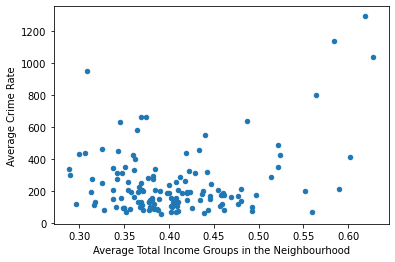

In [ ]:
# Data Plotted
clusteredData.plot.scatter(x = 'Average Total Income Groups in the Neighbourhood', y = 'Average Crime Rate')
plt.show()

13. Plot graph to find correlation between Average Crime Rate in the Neighbourhood and Population

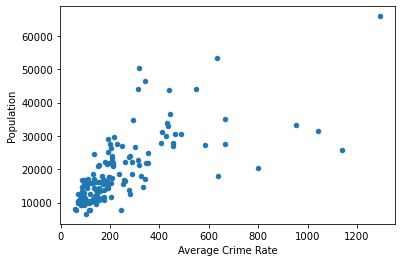

In [ ]:
#Data Plotted
clusteredData.plot.scatter(x = 'Average Crime Rate', y = 'Population')
plt.show()

14. Visualize all the Neighborhoods on the Map

In [ ]:
#Get latitude and longitude of Toronto
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
Torontolatitude = location.latitude
Torontolongitude = location.longitude

#Call to the api using the stored variables
url = "https://api.foursquare.com/v3/places/search?query={}&ll={},{}&radius={}".format('Police',Torontolatitude,Torontolongitude, 50)

headers = {
    "Accept": "application/json",
    "Authorization": "fsq3uy16JcMz2tA7tkTBxEgQtRVWIQ4V52GDK5ndFxXa0Co="
}

#Response from the call
response = requests.request("GET", url, headers=headers)

#Convert the data to JSON
json_data = json.loads(response.text)

# Visualize all Neighborhoods 
mymap = folium.Map(location=[Torontolatitude, Torontolongitude], zoom_start=11)
for Latitude, Longitude, Neighborhood in zip(neighbourhoodInformation['Latitude'], neighbourhoodInformation['Longitude'], neighbourhoodInformation['Neighbourhood']):
    label = '{}. {}. {}'.format(Neighborhood, Latitude, Longitude)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        parse_html=False).add_to(mymap)  

#Print the map
mymap

15. Find all the police stations near the neighborhoods within 10KM

In [ ]:
#Radius of 10km and diplay 50 police stations
radius = 10000
limit = 50
query = 'Police Station'
station = []

#For every neighborhood with latitude and longitude, Retrive all the police stations within 10KM
for Latitude, Longitude, neighbourhood in zip(clusteredDataWithLatLong['Latitude'], clusteredDataWithLatLong['Longitude'], clusteredDataWithLatLong['Neighbourhood']):
    url = "https://api.foursquare.com/v3/places/search?ll={}%2C{}&radius={}&query={}&limit={}".format(Longitude,Longitude,radius,query,limit)
    headers = {
        "Accept": "application/json",
        "Authorization": "fsq3uy16JcMz2tA7tkTBxEgQtRVWIQ4V52GDK5ndFxXa0Co="
    }
    #Get Results
    results = requests.request("GET", url, headers=headers).json()["results"]

    #Save the results
    for place in results:
        station.append((neighbourhood,Latitude,Longitude,place['name'], place['geocodes']['main']['latitude'], place['geocodes']['main']['longitude'],))

NameError: name 'clusteredDataWithLatLong' is not defined

16. Visualization of Geometry Coordinates for all Neighborhoods

In [ ]:
#Visualize all neighborhoods with the geometry labels
map = folium.Map(location=[Torontolatitude, Torontolongitude], zoom_start=11)
for x, r in neighbourhoodInformation.iterrows():
    geometry = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geoJ = geometry.to_json()
    geoJ = folium.GeoJson(data=geoJ, style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['Neighbourhood']).add_to(geoJ)
    geoJ.add_to(map)
map

17. Police Stations Data retrieved from FourSquare API

In [ ]:
#Create Data frame for Station Information
df = pd.DataFrame(station)
df.columns = ['Neighbourhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Station', 'Station Latitude', 'Station Longitude']

#Print out Station Information
df


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Station,Station Latitude,Station Longitude
0,Agincourt North,43.805441,-79.266712,"Toronto Police Service, Divisions, 42 Division",43.789177,-79.240020
1,Agincourt North,43.805441,-79.266712,Toronto Police Property Unit,43.774605,-79.267090
2,Agincourt North,43.805441,-79.266712,York Regional Police District 5 HQ,43.876477,-79.287645
3,Agincourt North,43.805441,-79.266712,Toronto Police Service - 43 Division,43.770656,-79.173907
4,Agincourt North,43.805441,-79.266712,"Toronto Police Service, Divisions, 41 Division",43.730515,-79.277079
...,...,...,...,...,...,...
3616,Yorkdale-Glen Park,43.714672,-79.457108,Toronto Police Service,43.661197,-79.384973
3617,Yorkdale-Glen Park,43.714672,-79.457108,Toronto Police Svc,43.756491,-79.551813
3618,Yorkdale-Glen Park,43.714672,-79.457108,"Toronto Police Service, Divisions, 23 Division",43.718423,-79.569583
3619,Yorkdale-Glen Park,43.714672,-79.457108,Cogient Corp,43.650135,-79.381155


18. Total Police Stations near each Neighborhoods within 10KM

In [ ]:
#Retrieve the Neighborhood names and Total Police Stations
countPoliceStations = pd.DataFrame(df['Neighbourhood'].value_counts().reset_index())
countPoliceStations.columns
countPoliceStations = countPoliceStations.rename(columns={'index':'Neighbourhood', 'Neighbourhood':'Police Stations'})


#Save to CSV File
countPoliceStations.to_csv("CleanDataSet/TotalPoliceStations.csv")
countPoliceStations


,Neighbourhood,Police Stations
0,Mount Pleasant West,44
1,Leaside-Bennington,43
2,Lawrence Park North,43
3,Mount Pleasant East,43
4,Lawrence Park South,43
...,...,...
135,West Hill,7
136,Morningside,7
137,Rouge,5
138,Centennial Scarborough,5


19. Create Two Final datasets
        1) With latitude, Longitude, and Geometry
        2) Without latitude, Longitude, and Geometry

In [ ]:
#Merge the datasets with
finalDataSet = pd.merge(clusteredData, countPoliceStations, on='Neighbourhood')
finalDataSetLongLat = pd.merge(clusteredDataWithLatLong, countPoliceStations, on='Neighbourhood')

#Print Datasets
finalDataSet
#finalDataSetLongLat

,Neighbourhood,Population,Average Crime Rate,Total People Working in Household,Average Total Income Groups in the Neighbourhood,Police Stations
0,Agincourt North,29113,193.1,9120,0.313262,9
1,Agincourt South-Malvern West,23757,275.1,8135,0.342425,10
2,Alderwood,12054,91.0,4620,0.383275,15
3,Annex,30526,486.6,15935,0.522014,38
4,Banbury-Don Mills,27695,200.8,12125,0.437805,31
...,...,...,...,...,...,...
135,Wychwood,14349,133.8,5885,0.410133,37
136,Yonge-Eglinton,11817,137.4,5680,0.480663,41
137,Yonge-St.Clair,12528,68.6,7015,0.559946,41
138,York University Heights,27593,665.6,10165,0.368391,18


20. Geometry Info for All Neighbourhoods

In [ ]:
#Create new Data frame for geometry values
geometryInfo = pd.DataFrame(finalDataSetLongLat, columns=['geometry'])
geometryInfo

,geometry
0,"POLYGON ((-79.24213 43.80247, -79.24319 43.802..."
1,"POLYGON ((-79.25498 43.78122, -79.25797 43.780..."
2,"POLYGON ((-79.54866 43.59022, -79.54876 43.590..."
3,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
4,"POLYGON ((-79.33055 43.73979, -79.33044 43.739..."
...,...
135,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
136,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
137,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
138,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."


21. Clustering the Data

In [ ]:
#New Dataframe for Clustering
ClusteredData=finalDataSet.copy(deep=True)
ClusteredPerformance = ClusteredData.drop(labels=['Neighbourhood'], axis=1)

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ClusteredPerformance)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[2:7] 
ClusteredData.insert(3, 'Cluster Labels', kmeans.labels_)

22. Add the Geometry Information to the clustered dataset

In [ ]:
#Add the polygon Geometry information
FinalDatasetPoly = pd.concat([ClusteredData, geometryInfo], join='inner', axis=1)
FinalDatasetPoly

,Neighbourhood,Population,Average Crime Rate,Cluster Labels,Total People Working in Household,Average Total Income Groups in the Neighbourhood,Police Stations,geometry
0,Agincourt North,29113,193.1,1,9120,0.313262,9,"POLYGON ((-79.24213 43.80247, -79.24319 43.802..."
1,Agincourt South-Malvern West,23757,275.1,0,8135,0.342425,10,"POLYGON ((-79.25498 43.78122, -79.25797 43.780..."
2,Alderwood,12054,91.0,3,4620,0.383275,15,"POLYGON ((-79.54866 43.59022, -79.54876 43.590..."
3,Annex,30526,486.6,1,15935,0.522014,38,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
4,Banbury-Don Mills,27695,200.8,1,12125,0.437805,31,"POLYGON ((-79.33055 43.73979, -79.33044 43.739..."
...,...,...,...,...,...,...,...,...
135,Wychwood,14349,133.8,3,5885,0.410133,37,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
136,Yonge-Eglinton,11817,137.4,3,5680,0.480663,41,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
137,Yonge-St.Clair,12528,68.6,3,7015,0.559946,41,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
138,York University Heights,27593,665.6,1,10165,0.368391,18,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."


23. Statistics Values for each datasets

In [ ]:
FinalDatasetPoly.describe()

,Population,Average Crime Rate,Cluster Labels,Total People Working in Household,Average Total Income Groups in the Neighbourhood,Police Stations
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,19511.221429,246.273571,1.521429,7949.428571,0.405608,25.864286
std,10033.589222,206.329192,1.343612,4794.749042,0.068062,11.723561
min,6577.000000,58.800000,0.000000,2650.000000,0.288197,4.000000
25%,12019.500000,119.175000,0.000000,5137.500000,0.361737,15.000000
50%,16749.500000,188.400000,1.000000,6572.500000,0.389001,26.000000
75%,23854.500000,289.700000,3.000000,9537.500000,0.439355,37.000000
max,65913.000000,1292.200000,3.000000,40750.000000,0.627951,44.000000


24. Plot Correlation between Average Crime Rate and Police Stations

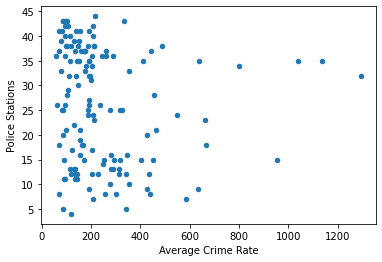

In [ ]:
#Plot Graph
FinalDatasetPoly.plot.scatter(x = 'Average Crime Rate', y = 'Police Stations'	)
plt.show()

25. K Mean Clustering

In [ ]:
# Get the K mean value 
ClusteredData.groupby('Cluster Labels').mean()

#Number 3 clusters are the most ideal location to live in Toronto as it has the lowest average Crime Rate and The most police Stations

,Population,Average Crime Rate,Total People Working in Household,Average Total Income Groups in the Neighbourhood,Police Stations
Cluster Labels,,,,,
0,19405.040000,227.890000,7814.900000,0.403285,24.780000
1,29705.120000,460.956000,12338.000000,0.414668,21.920000
2,49725.714286,554.885714,20385.000000,0.397379,15.142857
3,11562.258621,132.339655,4672.931034,0.404700,29.793103


26. Retrieve Each clusters geometry information

In [ ]:
#Cluster 0 Data
cluster0Data = FinalDatasetPoly['Cluster Labels'] == 0
Cluster0 = FinalDatasetPoly[cluster0Data]

#Cluster 1 Data
cluster1Data = FinalDatasetPoly['Cluster Labels'] == 1
Cluster1 = FinalDatasetPoly[cluster1Data]

#Cluster 2 Data
cluster2Data = FinalDatasetPoly['Cluster Labels'] == 2
Cluster2 = FinalDatasetPoly[cluster2Data]

#Cluster 3 Data
cluster3Data = FinalDatasetPoly['Cluster Labels'] == 3
Cluster3 = FinalDatasetPoly[cluster3Data]

27. Visualize the Ideal Location to live in Toronto

In [ ]:

#Add Toronto Location and zoom size with the Neighbourhood Information
map = folium.Map(location=[Torontolatitude, Torontolongitude], zoom_start=11)
for x, r in neighbourhoodInformation.iterrows():
    sGEO = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    jGEO = sGEO.to_json()
    jGEO = folium.GeoJson(data=jGEO, style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Neighbourhood']).add_to(jGEO)
    jGEO.add_to(map)

#Cluster 0 Data
for x, r in Cluster0.iterrows():
    sGEO = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    jGEO = sGEO.to_json()
    jGEO = folium.GeoJson(data=jGEO,style_function=lambda x: {'fillColor': 'yellow'})
    folium.Popup(r['Neighbourhood']).add_to(jGEO)
    jGEO.add_to(map)

#Cluster 1 Data
for x, r in Cluster1.iterrows():
    sGEO = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    jGEO = sGEO.to_json()
    jGEO = folium.GeoJson(data=jGEO,style_function=lambda x: {'fillColor': 'Orange'})
    folium.Popup(r['Neighbourhood']).add_to(jGEO)
    jGEO.add_to(map)

#Cluster 2 Data
for x, r in Cluster2.iterrows():
    sGEO = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    jGEO = sGEO.to_json()
    jGEO = folium.GeoJson(data=jGEO,
    style_function=lambda x: {'fillColor': 'red'})
    folium.Popup(r['Neighbourhood']).add_to(jGEO)
    jGEO.add_to(map)

#Cluster 3 Data
for x, r in Cluster3.iterrows():
    sGEO = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    jGEO = sGEO.to_json()
    jGEO = folium.GeoJson(data=jGEO,
    style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['Population']).add_to(jGEO)
    jGEO.add_to(map)

map